<h1 style="text-align:center"> Preparation of complex after embedding 
</h1>

> `confout.gro`

>  Output coordinate file after embedding. This contains protein, lipids, and water (from original solvated bilayer file) coordinates.

Generate protein-lipids only PDB

**First**, make index file and create `Protein_POPC` group, and delete any other group.

```bash
printf "1|13\ndel 0-23\nq\n" | gmx_mpi make_ndx -f ${outfolder}/complex/confout.gro -o ${outfolder}/complex/protein+lipids.ndx
```

**Second**, pass previous index file to `editconf` and extract coordinates and save in PDB 

```bash
gmx_mpi editconf -f ${outfolder}/complex/confout.gro -n ${outfolder}/complex/protein+lipids.ndx -o ${outfolder}/complex/protein+lipids.pdb
```

> **NOTE**: generated PDB has **no label or chain separation** for protein coordinates, but **residue order is preserved** though. 

**Third**, use *SOLVATE* to obtain protein-bilayer solvation layers
```bash
~/solvate_1.0/solvate -t 3 -n 8 -w ${outfolder}/complex/protein+lipids ${outfolder}/complex/solvation_layer
```

> Here, flags *-t*, *-n*, and *-w* will respectively refer to i) thickness of solvation layer (Angstroms), number of gaussians used (?), and water coordinates in separate PDB. **Note that** no `.pdb` extension should be added. 

> ** <span style="color:red">IMPORTANT NOTE</span>**: By default, water residue name will be `TIP3`, with oxygen and hydrogens with atom names: `OH2`, `H1` and `H2`. This naming convention is compatible with *CHARMM* force field. But, ir preparing an input PDB with a different force field, all these names **must** be modified (Use PyMOL)

**Fourth**, merge altered solvation layer PDB and protein-lipids PDB
```bash
head -n -2 protein+lipids.pdb >> protein+lipids+sol_layer.pdb
cat solvation_layer.pdb >> protein+lipids+sol_layer.pdb
```

Protein and bilayer complex with *SOLVATE* added solvation layer

<img src="protein+lipids_solvation_layer.png" height="800" width="800">


**Fifth**, alter atom names and residue names in generated `solvation_layer.pdb`, to be compatible with OPLS/AA convention for *SPC water model*. Used PyMOL:

`alter_solvation_layer.py`

```python
#######################################
import sys
from pymol import cmd

solvated_output = sys.argv[1] # PDB file 
altered_pdb = sys.argv[2]

cmd.load(solvated_output, 'System')

cmd.select("sele", "resn tip3")
cmd.alter("sele", "resn='SOL'")
cmd.select("sele_Os", "name OH2 and resn SOL")
cmd.alter("sele_Os", "name='OW'")
cmd.select("sele_H1s", "name H1 and resn SOL")
cmd.alter("sele_H1s", "name='HW1'")
cmd.select("sele_H2s", "name H2 and resn SOL")
cmd.alter("sele_H2s", "name='HW2'")

cmd.set("retain_order",1)
cmd.save(altered_pdb, 'System')
#######################################
```

Then, in command line:
```bash
pymol -qc alter_solvation_layer.py -- protein+lipids+sol_layer.pdb protein+lipids+sol_layer_altered.pdb

```

> **<span style="color:red">NOTE</span>**: This PyMOL script can fail if the PyMOL version has not been correctly compiled to accept a limit beyond 5-digit atoms numbers. 
> *SOLUTION*: Recompile or update PyMOL (Version 2.0).

**Sixth**, add chain labels for residue lines.

`label_chains4gro.py`

```bash
#######################################
import sys
from pymol import cmd

pdb_in = sys.argv[1]   # input pdb
pdb_out = sys.argv[2]  # output pdb 

# Number of chains 
nchains = 8
# Load input pdb
cmd.load(pdb_in, "System")
cmd.select("MyProtein", "not(resn POPC SOL)")
# Number of atoms per chain
N = float(cmd.count_atoms("MyProtein"))/float(nchains)
# List of chain labels
chains = ['A','B','C','D','E','F','G','H']

for i in range(nchains):
        # Select all atoms in chain range and relabel
        chn_sele = 'id '+str(1+i*(N+1))+'-'+str((i+1)*(N+1))
        cmd.select("sele", chn_sele)
        cmd.alter("sele", "chain="+"'"+chains[i]+"'")

# Retain order of atoms in PDB and save
cmd.set("retain_order",1)
cmd.save(pdb_out, "System")
#######################################
```

**<span style="color:red">NOTE</span>**: The automatic addition of `TER` line in PDBs can be en(dis)abled using:

```python
cmd.set('pdb_use_ter_records', 0) # disable
cmd.set('pdb_use_ter_records', 1) # enable
```
 
https://pymolwiki.org/index.php/Pdb_use_ter_records

<span style="color:red">Disabled?</span>

```bash
pymol -qc label_chains4gro.py -- protein+lipids+sol_layer_altered.pdb protein_chains+lipids+sol_layer_altered.pdb
```

**Seventh**, redefine box dimensions, centering system.

```bash
Lx=12.9135 # Original size
Ly=12.7905 # Original size
Lz=10.0626 # New size 

gmx_mpi editconf -f protein_chains+lipids+sol_layer_altered.pdb -o protein_chains+lipids+sol_layer_altered.pdb -c -box $Lx $Ly $Lz
```

**Eigth**, solvate box with ice-water. This will fill the empty spaces in the box with waters; SPC (Simple Point Charge) *water model*.

```bash
# Correct topol.top. Remove SOL line,
sed -i '/SOL/d' topol.top

# Then, correct number of waters
N_waters=$(grep TIP3 protein+lipids+sol_layer.pdb| wc -l|awk '{print $1/3}')
printf "SOL\t\t $N_waters\n" >> topol.top

# Resolvate:
gmx_mpi solvate -cp protein_chains+lipids+sol_layer_altered.pdb -p topol.top -cs spc216.gro -o protein+lipids+sol_RAW.pdb

# Correct topol.top again
N_waters_total=$(grep SOL topol.top | awk '{s+=$2} END{printf "SOL\t\t "s}')
sed -i '/SOL/d' topol.top
echo $N_waters_total >> topol.top
```

Up to this point, you should be able to get a simulation box which looks just like this 

<img src=protein+lipids+sol_RAW.png height="800" width="800">

we can see that the added ice-water molecules fill in the simulation box, whereas the ones of protein-lipids' the solvation layer go beyond the box boundaries, as expected.

## Removal of water from bilayer interior and protein-bilayer interface

**Find the position of phosphorus P8 in POPC phosphate group**

In [557]:
path = "/projects/s21/ba13026/mytest/test3/output/complex/"

In [558]:
in_file = path+"protein+lipids+sol_RAW.pdb" 
ifile   = open(in_file, 'r')
lines   = ifile.readlines()
ifile.close()

In [559]:
# Extract Lipid Phosphate (P8) atomic coordinates: Z-axis
P8_z = [float(l.split()[7]) for l in lines if re.search(r"P8", l)]
P8_z_mean  = numpy.mean(P8_z)
# Average Z-axis postions, upper leaflet
P8_z_Upper = [z for z in P8_z if z>P8_z_mean]
P8_z_Upper_mean  = numpy.mean(P8_z_Upper)
# Average Z-axis postions, lower leaflet
P8_z_Lower = [z for z in P8_z if z<P8_z_mean]
P8_z_Lower_mean  = numpy.mean(P8_z_Lower)
#del P8_z

Average Z-position (Angstroms) of P8 atoms of lower and upper leaflets 

In [560]:
P8_z_Lower_mean, P8_z_Upper_mean

(28.766147410358567, 70.16535059760956)

<img src="p8_atoms.png" height="800" width="800" >

**Remove waters outside box**

In [561]:
box_dim = list(map(float,[l.split()[1:4] for l in lines if re.search(r"CRYST",l)][0]))
Lx,Ly,Lz = box_dim

In [562]:
SOL = [l for l in lines if re.search(r'SOL', l)]

In [563]:
for i in range(0,len(SOL),3):
    atom = SOL[i].split()[-1]
    if atom != 'O':
        SOL[i] = SOL[i][:-1] + "           O\n"
        SOL[i+1] = SOL[i+1][:-1] + "           H\n"
        SOL[i+2] = SOL[i+2][:-1] + "           H\n"

In [564]:
SOL_data = SOL
N = len(SOL_data)
SOL_box = []
r_xy_SOL_box = []
for i in range(0,N,3):
        x,y,z = list(map(float,SOL_data[i].split()[-6:-3]))
        r_xy = numpy.linalg.norm(numpy.array([x,y]) - protein_com[:2])
        if (0 < x < Lx):
            if ( 0 < y < Ly):
                if (0 < z < Lz):
                    r_xy_SOL_box.append([z, r_xy])
                    SOL_box.append(SOL_data[i])
                    SOL_box.append(SOL_data[i+1])
                    SOL_box.append(SOL_data[i+2])

In [565]:
print("Initial number of waters: ", N)
print("Number of waters within box boundaries: ", len(SOL_box))
print("Percentage surviving: ", str(len(SOL_box)/float(N)*100)+" %")

Initial number of waters:  166515
Number of waters within box boundaries:  110967
Percentage surviving:  66.64084316728223 %


**Remove waters within bilayer and protein-lipids interface**

**First**, find centre of mass of protein and primitive curves per chain

First, for preparation: create index file, generate protein PDB with new coordinates, then fix PDB adding TER entries for chain separation; this will be needed to use *Isambard*

```bash
printf "q\n" | gmx_mpi make_ndx -f protein+lipids+sol_RAW.pdb -o protein+lipids+sol_RAW.ndx

echo "Protein" | gmx_mpi editconf -f protein+lipids+sol_RAW.pdb -n protein+lipids+sol_RAW.ndx -o protein_RAW.pdb

pymol -qc add_ter.pymol -- protein_RAW.pdb protein_RAW.pdb
```

**<span style="color:red">NOTE</span>**: This last step is uneccessary, since *Isambard* doesn't need `TER` cards to identify residues per chain in PDB.

This PyMOL script will automatically(*) add a `TER` entry in `protein_RAW.pdb`

`add_ter.pymol`

```python
#######################################
import sys

pdb_in = sys.argv[1]
pdb_out = sys.argv[2]

cmd.load(pdb_in, "Protein")
cmd.save(pdb_out, "Protein")
#######################################
```

(\*) **<span style="color:red">NOTE</span>**: Not always the case. This is not working properly for PyMOL Version 2.0

In [920]:
import numpy, re
import isambard_dev
%matplotlib notebook

In [566]:
protein = isambard_dev.ampal.convert_pdb_to_ampal(path+"protein_RAW.pdb")

In [567]:
protein_com = numpy.array(protein.centre_of_mass)
print(protein_com)

[ 62.17831765  64.3998195   49.4635535 ]


In [568]:
ampal = protein
prims = numpy.array([x.coordinates for x in ampal.primitives])
ref_axis = isambard_dev.ampal.pseudo_atoms.Primitive.from_coordinates(
        numpy.mean(prims, axis=0))

<IPython.core.display.Javascript object>


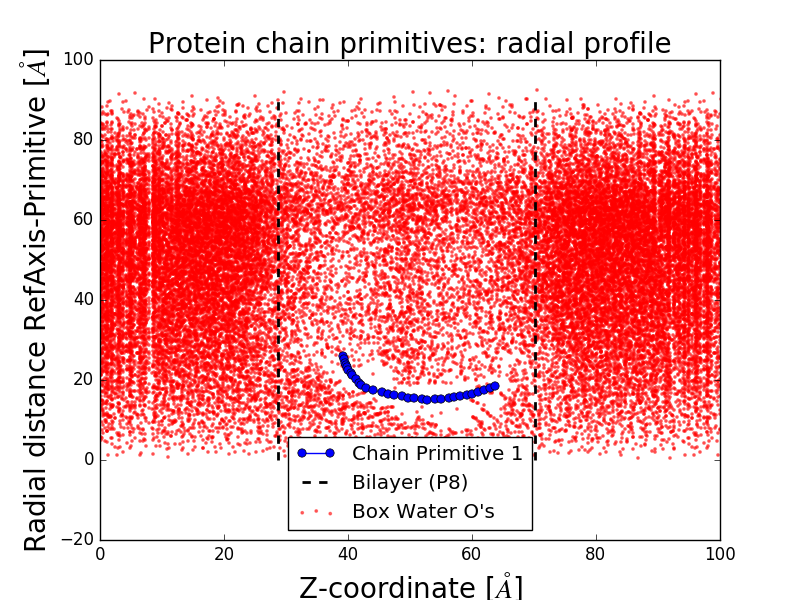

In [569]:
fig = plt.figure(dpi=100)

for i in range(1):
    dist = prims[i] - ref_axis.coordinates
    x = numpy.array(ref_axis.coordinates).T[2]
    y = numpy.linalg.norm(dist, axis=1)
    plt.plot(x,y,marker = 'o', label="Chain Primitive "+str(i+1))

X,Y = numpy.array(r_xy_SOL_box).T
plt.scatter(X,Y, marker="o", color="red", s=3, label="Box Water O's", alpha=0.5)

plt.plot((P8_z_Lower_mean, P8_z_Lower_mean),(0,90),linestyle="--",color="black",linewidth=2, label="Bilayer (P8)")
plt.plot((P8_z_Upper_mean, P8_z_Upper_mean),(0,90),linestyle="--",color="black",linewidth=2)

plt.title("Protein chain primitives: radial profile",fontsize=20)
plt.xlabel("Z-coordinate [$\AA$]", fontsize=20)
plt.ylabel("Radial distance RefAxis-Primitive [$\AA$]",fontsize=20)

plt.legend(loc="best")
#plt.axis('equal')
plt.xlim(0,100)
#plt.ylim(0,100)

plt.show()

Find chain radial profile for protein and define a partition 

In [570]:
dist = prims[0] - ref_axis.coordinates
R_profile = numpy.linalg.norm(dist, axis=1)

In [571]:
primitive_z = numpy.array(ref_axis.coordinates).T[2]

protein_z_partition = []
for i in range(len(primitive_z)-1):
    lower_lim = primitive_z[i]
    upper_lim = primitive_z[i+1]
    rad_lim = R_profile[i]
    protein_z_partition.append([lower_lim, upper_lim, rad_lim])

In [572]:
R_low = R_profile[0]
R_upper = R_profile[-1]
total_z_partition = [[P8_z_Lower_mean, primitive_z.min(), R_low]] \
    + protein_z_partition  \
    + [[primitive_z.max(), P8_z_Upper_mean, R_upper]]

Remove lines from list that do not fullfil criterion

**Waters inside protein and between bilayer leaflets**

In [573]:
SOL_data = SOL_box
N = len(SOL_data)
r_xy_SOL_inside = []
SOL_inside_indices = []
for s in total_z_partition:
    lower_lim = s[0]
    upper_lim = s[1]
    rad_lim = s[2]
    for i in range(0,N,3):
        x,y,z = list(map(float,SOL_data[i].split()[-6:-3]))
        r_xy = numpy.linalg.norm(numpy.array([x,y]) - protein_com[:2])
        if (lower_lim < z <= upper_lim) and (r_xy < rad_lim):
            r_xy_SOL_inside.append([z, r_xy]) # For visualisation
            SOL_inside_indices.append(i)

**Waters outside bilayer**

In [574]:
SOL_data = SOL_box
N = len(SOL_box)
r_xy_SOL_outside = []
SOL_outside_indices = []
for i in range(0,N,3):
    x,y,z = list(map(float,SOL_data[i].split()[-6:-3]))
    r_xy = numpy.linalg.norm(numpy.array([x,y]) - protein_com[:2])
    if (z <= P8_z_Lower_mean) or (z > P8_z_Upper_mean):
        r_xy_SOL_outside.append([z, r_xy]) # For visualisation
        SOL_outside_indices.append(i)

<IPython.core.display.Javascript object>


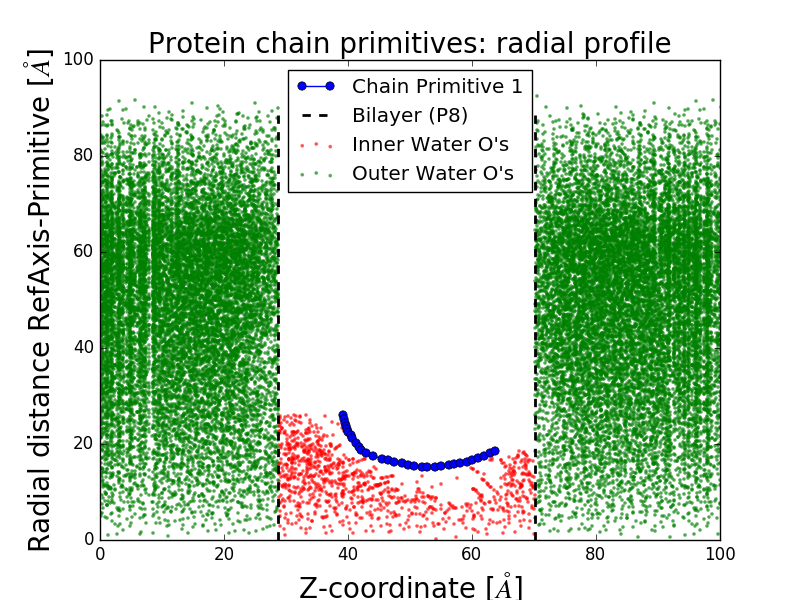

In [575]:
fig = plt.figure(dpi=100)

for i in range(1):
    dist = prims[i] - ref_axis.coordinates
    x = numpy.array(ref_axis.coordinates).T[2]
    y = numpy.linalg.norm(dist, axis=1)
    plt.plot(x,y,marker = 'o', label="Chain Primitive "+str(i+1))

plt.plot((P8_z_Lower_mean,P8_z_Lower_mean),(0,90),linestyle="--",color="black",linewidth=2,label="Bilayer (P8)")
plt.plot((P8_z_Upper_mean,P8_z_Upper_mean),(0,90),linestyle="--",color="black",linewidth=2)

plt.title("Protein chain primitives: radial profile", fontsize=20)
plt.xlabel("Z-coordinate [$\AA$]", fontsize=20)
plt.ylabel("Radial distance RefAxis-Primitive [$\AA$]", fontsize=20)

X,Y = numpy.array(r_xy_SOL_inside).T
plt.scatter(X,Y, marker="o", color="red", s=3, label="Inner Water O's", alpha=0.5)

X,Y = numpy.array(r_xy_SOL_outside).T
plt.scatter(X,Y, marker="o", color="green", s=3, label="Outer Water O's", alpha=0.5)

plt.legend(loc="best")
#plt.axis('equal')
plt.xlim(0,100)
plt.ylim(0,100)

plt.show()

Merge solvent indeces and select water coordinates accordingly, 

In [576]:
SOL_filtered_indeces = SOL_inside_indices + SOL_outside_indices
SOL_filtered_indeces.sort()

In [578]:
len(SOL_filtered_indeces)

30609

*Fix topology* `topol.top` using above number

In [579]:
SOL_filtered = []
for index in SOL_filtered_indeces:
    SOL_filtered.append(SOL_box[index])
    SOL_filtered.append(SOL_box[index+1])
    SOL_filtered.append(SOL_box[index+2])

Finally, merge filtered water coordinates with protein and lipid ones; save into clean PDB.

In [580]:
pdb_prot_popc = []
for l in lines:
        if re.search(r"SOL", l):
                break
        else:
            pdb_prot_popc.append(l)

In [581]:
out_file = path+'protein+lipids+sol_clean.pdb'
ofile    = open(out_file, 'w')
for l in pdb_prot_popc:
    ofile.write(l)
for l in SOL_filtered:
    ofile.write(l)
ofile.close()

Screenshot of *complex* with removed waters within bilayer and protein-lipid interface; water molecules within protein pore are preserved, as expected.

<img src="clean_pdb.png" height="800" width="800">

**Finally**, add K-Cl ions to the system, at 1M concentration

```bash
gmx_mpi grompp -f mdpf/ionise.mdp -c protein+lipids+sol_clean.pdb -o ionise.tpr -p topol.top

# Set KCl electrolyte, at 1 M concentration (neutral)
echo "SOL" | gmx_mpi genion -s ionise.tpr -p topol.top -o ionise.pdb -conc 1.0 -pname K -nname CL -neutral

```

<img src="ionised_1M_KCL.png" height="800" width="800">

**TO-DO**
<span style="color:red"> Compute radial dist func to see if distance from solvent to prot atoms is preserved, to indicate that sol were not incorrectly filtered</span>

http://manual.gromacs.org/programs/gmx-rdf.html 

<h1 style="text-align:center">Smooth Energy Minimization (sEM)</h1>

Proposed stages of smooth *energy minimization*:

* Stage 1
 Restrain: POPC and Protein; EM: Water, Ions. All bonds constrained.

* Stage 2
 Restrain: Protein; EM: Water, Ions, POPC. All bonds constrained.

* Stage 3
 Restrain: Protein-BB; EM: Water, Ions, POPC, Protein-SC. All bonds constrained.

* Stage 4
 Restrain: Nothing; EM: everything. All bonds constrained

* Stage 5
 Restrain: Nothing; EM: everything. All bonds *unconstrained*

## 1. Preparation of restraints

For a progressive relaxation, prior to MD production, restraints will be applied to all atom groups in the system, and gradually removed at different stages while monitoring *potential energy* in order to assess relaxation of the system.

First, we need to prepare restraints for the following groups:

1. Lipids, 
2. Side-chain protein atoms,
3. Backbone protein atoms.




`topol.top`, `topol_POPC.itp` and `posres_POPC.itp`

`sem.mdp`

**First**, generate position restraint files with the format below

```bash
[ position_restraints ]
;  i funct       fcx        fcy        fcz
   1    1       3000       3000       3000
   2    1       3000       3000       3000
   3    1       3000       3000       3000
   4    1       3000       3000       3000
   5    1       3000       3000       3000
   6    1       3000       3000       3000
   7    1       3000       3000       3000
   8    1       3000       3000       3000
   9    1       3000       3000       3000
   .......................................
```

First, this **must** contain a label `[ position_restraints ]` at the top, below which 4 columns are included; the *first* relates to the **atom number in the individual topology file** (e.g., `topol_POPC.itp`) of the group you want to restrain, ** not in the PDB**; the *second* refers to the *function type* used for restraining, usually based on a harmonic potential (`type 1`):

$$
U = \frac{1}{2} k_x(x - x_0)^2 + \frac{1}{2} k_y(y - y_0)^2 + \frac{1}{2} k_z(z - z_0)^2
$$

The *last three columns* are the force constants; $k_x$, $k_y$, and $k_z$  [*kJ/ mol* $nm^2$].


**Note**: `posre_Protein_chain_X.itp` restrain files already lists restraints information for backbone atoms with the corresponding atom numbers for `N, CA, CB` and `O` atoms as in `topol_Protein_chain_X.itp`

So, to generate the coresponding restraints for all protein atoms (`Protein_SC-BB_chain_X`); sidechains and backbone atoms, we just need to add restraints for all atom numbers in `topol_Protein_chain_X.itp`

Restraints for the lipid atoms can be generated in a similat way, just by restraint informations for all atom numbers listed in `topol_POPC.itp`.

In the end, we should have the whole set of restraint files listed below.

```bash
# All lipid atoms
posre_POPC.itp

# All atoms per protein chain
posre_Protein_SC+BB_chain_A.itp
posre_Protein_SC+BB_chain_B.itp
posre_Protein_SC+BB_chain_C.itp
posre_Protein_SC+BB_chain_D.itp
posre_Protein_SC+BB_chain_E.itp
posre_Protein_SC+BB_chain_F.itp
posre_Protein_SC+BB_chain_G.itp
posre_Protein_SC+BB_chain_H.itp

# All backbone atoms per protein chain
posre_Protein_BB_chain_A.itp
posre_Protein_BB_chain_B.itp
posre_Protein_BB_chain_C.itp
posre_Protein_BB_chain_D.itp
posre_Protein_BB_chain_E.itp
posre_Protein_BB_chain_F.itp
posre_Protein_BB_chain_G.itp
posre_Protein_BB_chain_H.itp
```

*Why not freezing atomic groups instead of restraining them?*

**freezegrps**:

Groups that are to be frozen (i.e. their X, Y, and/or Z position will not be updated; e.g. Lipid SOL). freezedim specifies for which dimension the freezing applies. <span style="color:red">To avoid spurious contibrutions to the virial and pressure due to large forces between completely frozen atoms you need to use energy group exclusions, this also saves computing time</span>. Note that coordinates of frozen atoms are not scaled by pressure-coupling algorithms.

**freezedim**:

dimensions for which groups in freezegrps should be frozen, specify Y or N for X, Y and Z and for each group (e.g. Y Y N N N N means that particles in the first group can move only in Z direction. The particles in the second group can move in any direction).

*Source*: http://manual.gromacs.org/online/mdp_opt.html



**<span style="color:red">IMPORTANT NOTE:</span>** avoid using genrestr

> Further, the atom index of each [position_restraint] must be relative to the [moleculetype], not relative to the system (because the parsing has not reached [molecules] yet, there is no such concept as "system"). So you cannot use the output of a tool like genrestr blindly (as genrestr -h warns).

Source: http://www.gromacs.org/Documentation/Errors#Atom_index_n_in_position_restraints_out_of_bounds

> WARNING: Position restraints are interactions within molecules, therefore they must be included within the correct [ moleculetype ] block in the topology. The atom indices within the [ position_restraints ] block must be within the range of the atom indices for that molecule type. Since the atom numbers in every moleculetype in the topology start at 1 and the numbers in the input file for gmx genrestr number consecutively from 1, gmx genrestr will only produce a useful file for the first molecule. You may wish to edit the resulting index file to remove the lines for later atoms, or construct a suitable index group to provide as input to gmx genrestr.

Source: http://manual.gromacs.org/programs/gmx-genrestr.html

## 2. Modification of group topology files

The general topology file, `topol.top` includes (amongst other information) references to individual `.itp` topology files per atomic group, e.g., `topol_Protein_chain_A.itp` or `topol_POPC.itp`. See below:

`topo.top`

```bash
; Include lipid-protein forcefield parameters
#include "ffoplsaa_berger.itp"

; Include POPC topology
#include "topol_POPC.itp"

#include "oplsaa.ff/spc.itp"
#include "oplsaa.ff/ions.itp"

; Include chain topologies
#include "topol_Protein_chain_A.itp"
#include "topol_Protein_chain_B.itp"
#include "topol_Protein_chain_C.itp"
#include "topol_Protein_chain_D.itp"
#include "topol_Protein_chain_E.itp"
#include "topol_Protein_chain_F.itp"
#include "topol_Protein_chain_G.itp"
#include "topol_Protein_chain_H.itp"

#ifdef POSRES_WATER
; Position restraint for each water oxygen
[ position_restraints ]
;  i funct       fcx        fcy        fcz
   1    1       1000       1000       1000
#endif

[ system ]
; Name
Protein in POPC in water

[ molecules ]
; Compound        #mols
Protein_chain_A     1
Protein_chain_B     1
Protein_chain_C     1
Protein_chain_D     1
Protein_chain_E     1
Protein_chain_F     1
Protein_chain_G     1
Protein_chain_H     1
POPC              503
SOL         28024
K                995
CL               1011

```

At the same time, individual topology `.itp` files point to *position restrain* files within them. For example, `topol_Protein_chain_A.itp` will contain references to the restraint files `posre_Protein_SC+BB_chain_A.itp` and `posre_Protein_BB_chain_A.itp`, as below:

```bash
; Position restraint SC and BB
#ifdef POSRES_SC_BB
#include "posre_Protein_SC+BB_chain_A.itp"
#endif

; Position restraint BB only
#ifdef POSRES_BB
#include "posre_Protein_BB_chain_A.itp"
#endif

```

Another example, at the bottom of `topol_POPC.itp` we include the pointer to the restraint file `posres_POPC.itp`, using the lines:

```bash
#ifdef POSRES_POPC
#include "posre_POPC.itp"
#endif
```

These references are only effective to enable restraints through the flags `POSRES_SC_BB`, `POSRES_BB` or `POSRES_POPC`, which can be selectively invoked within a parameter file (`.mdp`), using the `define` option, as below.

Sample of an `.mdp` file where postion restraints for protein _side chains_ and _backbone_ atoms and lipid atoms are enabled.


```
constraints         =  all-bonds
define              =  -DPOSRES_POPC -DPOSRES_SC_BB
integrator          =  steep
nsteps              =  20000
emtol               =  200
emstep              =  0.01
nstcomm             =  1
ns_type             =  grid
rlist               =  1.0
coulombtype         =  pme
rcoulomb            =  1.0
vdwtype             =  cut-off
rvdw                =  1.0
Tcoupl              =  no
Pcoupl              =  no
gen_vel             =  no
```

Note the prefix `-D` added to each flag.

Set of essential `.mdp` files per sequential sEM stage.

```
sem_PR-POPC_SC+BB_Protein_Cbonds.mdp  
sem_PR-SC+BB_Protein_Cbonds.mdp
sem_PR-BB_Protein_Cbonds.mdp  
sem_No-PR_Cbonds.mdp  
sem_No-PR_Ubonds.mdp  
```

The above files can be generated by running `gen_posres.sh`, just pass the folder path (without slash at the end!) as argument when running in the terminal.

` ~/mpmodeling/protocols/sem/gen_posres.sh`

```bash
#!/bin/bash

#path='.'
path=$1
######################################################################
for X in A B C D E F G H; do
# Modify chain topology files
head -n -5 ${path}/topol_Protein_chain_${X}.itp > ${path}/topol_Protein_chain_${X}.temp.itp;

printf -- "
; Position restraint SC and BB
#ifdef POSRES_SC_BB
#include \"posre_Protein_SC+BB_chain_%s.itp\"
#endif

; Position restraint BB only
#ifdef POSRES_BB
#include \"posre_Protein_BB_chain_%s.itp\"
#endif\n" $X $X >> ${path}/topol_Protein_chain_${X}.temp.itp;

mv ${path}/topol_Protein_chain_${X}.itp  ${path}/topol_Protein_chain_${X}.itp.bak;
mv ${path}/topol_Protein_chain_${X}.temp.itp  ${path}/topol_Protein_chain_${X}.itp;
done
######################################################################
# Protein-SC+BB restraints
for X in  A B C D E F G H; do
# Print header
printf -- "
; position restraints for Protein of Protein in POPC in water

[ position_restraints ]
;  i funct       fcx        fcy        fcz\n" > ${path}/posre_Protein_SC+BB_chain_${X}.itp;

# Print atom numbers from topology file and force vectors
awk '/\[ atoms \]/,/\[ bonds \]/ {print $1}' ${path}/topol_Protein_chain_${X}.itp |
grep -o '[0-9]\+' |
awk '{printf "%4.i    1       3000       3000       3000\n",$1}' >> ${path}/posre_Protein_SC+BB_chain_${X}.itp;
done
######################################################################
# Protein-BB restraints
for X in  A B C D E F G H; do
# Rename default posres files
cp ${path}/posre_Protein_chain_${X}.itp ${path}/posre_Protein_chain_${X}.itp.bak
mv ${path}/posre_Protein_chain_${X}.itp  ${path}/posre_Protein_BB_chain_${X}.itp;
# Increase restraining force
sed -i 's/1000/3000/g' ${path}/posre_Protein_BB_chain_${X}.itp;
done
######################################################################
# Lipid POPC restraints
printf -- "
; position restraints for POPC of Protein in POPC in water

[ position_restraints ]
;  i funct       fcx        fcy        fcz\n" > ${path}/posre_POPC.itp;

# Print atom numbers from topology file and force vectors
awk '/\[ atoms \]/,/\[ bonds \]/ {print $1}' ${path}/topol_POPC.itp |
grep -o '[0-9]\+' |
awk '{printf "%4.i    1       3000       3000       3000\n",$1}' >> ${path}/posre_POPC.itp
######################################################################
```

<h1 style="text-align:center"> Smooth *energy minimization* performance </h1>

Proposed stages of smooth *energy minimization*:

* Stage 1
 Restrain: POPC and Protein; EM: Water, Ions. All bonds constrained.

* Stage 2
 Restrain: Protein; EM: Water, Ions, POPC. All bonds constrained.

* Stage 3
 Restrain: Protein-BB; EM: Water, Ions, POPC, Protein-SC. All bonds constrained.

* Stage 4
 Restrain: Nothing; EM: everything. All bonds constrained

* Stage 5
 Restrain: Nothing; EM: everything. All bonds *unconstrained*

**NOTE**:

* 537 atoms in each protein chain
* All `posre_Protein_chain_*.itp` files are identical
* `posre_Protein.itp` contains restraints for all atoms in Protein
* Created restrain files for `SC-BB` (all atoms) and `BB` protein groups:

```bash
for x in A B C D E F G H ; do cp posre_Protein.itp posre_Protein_SC-BB_chain_${x}.itp ; done

for x in A B C D E F G H ; do cp posre_Protein_chain_A.itp posre_Protein_BB_chain_${x}.itp ; done
```



**FIRST**: EM water and ions, but keep POPC and all atoms in protein restrained:

```bash
gmx_mpi grompp -f mdpf/em_PR-POPC_SC-BB_Protein.mdp -c ionise.pdb -p topol.top -o em/em_PR-POPC_SC-BB_Protein.tpr

nohup  mpirun -np 20 mdrun_mpi -s em/em_PR-POPC_SC-BB_Protein.tpr -deffnm em/em_PR-POPC_SC-BB_Protein &

gmx_mpi energy -f em/em_PR-POPC_SC-BB_Protein.edr -o em/energy_em_PR-POPC_SC-BB_Protein.xvg
```

**SECOND**: Release POPC and keep SC-BB protein atoms restrained:

```bash
gmx_mpi grompp -f mdpf/em_PR-SC-BB_Protein_after_em_PR-POPC_SC-BB_Protein.mdp -c em/em_PR-POPC_SC-BB_Protein.gro -p topol.top -o em/em_PR-SC-BB_Protein_after_em_PR-POPC_SC-BB_Protein.tpr

nohup  mpirun -np 20 mdrun_mpi -s em/em_PR-SC-BB_Protein_after_em_PR-POPC_SC-BB_Protein.tpr -deffnm em/em_PR-SC-BB_Protein_after_em_PR-POPC_SC-BB_Protein &

# Calculate total potential energy
gmx_mpi energy -f em/em_PR-SC-BB_Protein_after_em_PR-POPC_SC-BB_Protein.edr -o em/energy_em_PR-SC-BB_Protein_after_em_PR-POPC_SC-BB_Protein.xvg
```

**THIRD**: Release POPC and SC-protein atoms, kep BB protein atoms restrained:

```bash
gmx_mpi grompp -f mdpf/em_PR-BB_Protein_after_em_PR-SC-BB_Protein.mdp -c em/em_PR-SC-BB_Protein_after_em_PR-POPC_SC-BB_Protein.gro -p topol.top -o em/em_PR-BB_Protein_after_em_PR-SC-BB_Protein.tpr

nohup  mpirun -np 20 mdrun_mpi -s em/em_PR-BB_Protein_after_em_PR-SC-BB_Protein.tpr -deffnm em/em_PR-BB_Protein_after_em_PR-SC-BB_Protein &

gmx_mpi energy -f em/em_PR-BB_Protein_after_em_PR-SC-BB_Protein.edr -o em/energy_em_PR-BB_Protein_after_em_PR-SC-BB_Protein.xvg
```

**FOURTH**: Totally unrestrained system

```bash
gmx_mpi grompp -f mdpf/em_after_em_PR-BB_Protein.mdp -c em/em_PR-BB_Protein_after_em_PR-SC-BB_Protein.gro -p topol.top -o em/em_after_em_PR-BB_Protein.tpr

nohup  mpirun -np 20 mdrun_mpi -s em/em_after_em_PR-BB_Protein.tpr -deffnm em/em_after_em_PR-BB_Protein &

gmx_mpi energy -f em/em_after_em_PR-BB_Protein.edr -o em/energy_em_after_em_PR-BB_Protein.xvg
```

**FIFTH**: Totally unrestrained system

```bash
gmx_mpi grompp -f mdpf/em_unconstrained_after_em_constrained.mdp -c em/em_after_em_PR-BB_Protein.gro -p topol.top -o em/em_unconstrained_after_em_constrained.tpr

nohup  mpirun -np 20 mdrun_mpi -s em/em_unconstrained_after_em_constrained.tpr -deffnm em/em_unconstrained_after_em_constrained &

gmx_mpi energy -f em/em_unconstrained_after_em_constrained.edr -o em/energy_em_unconstrained_after_em_constrained.xvg
```

**<span style="color:blue">COMPARISON</span>**:

No PR, unconstrained (`none`): *This is the most rough energy minimization of all*

```bash
gmx_mpi grompp -f mdpf/em_unconstrained.mdp -c ionise.pdb -p topol.top -o em/em_unconstrained.tpr

nohup  mpirun -np 20 mdrun_mpi -s em/em_unconstrained.tpr -deffnm em/em_unconstrained &

gmx_mpi energy -f em/em_unconstrained.edr -o em/energy_em_unconstrained.xvg
```

---

No PR, constrained (`all-bonds`):

```bash
gmx_mpi grompp -f mdpf/em_constrained.mdp -c ionise.pdb -p topol.top -o em/em_constrained.tpr

nohup  mpirun -np 20 mdrun_mpi -s em/em_constrained.tpr -deffnm em/em_constrained &

gmx_mpi energy -f em/em_constrained.edr -o em/energy_em_constrained.xvg
```

Then, perfom unconstrained EM afterwards:

```bash
gmx_mpi grompp -f mdpf/em_unconstrained_after_em_constrained_rough.mdp -c em/em_constrained.gro -p topol.top -o em/em_unconstrained_after_em_constrained_rough.tpr

nohup  mpirun -np 20 mdrun_mpi -s em/em_unconstrained_after_em_constrained_rough.tpr -deffnm em/em_unconstrained_after_em_constrained_rough &

gmx_mpi energy -f em/em_unconstrained_after_em_constrained_rough.edr -o em/energy_em_unconstrained_after_em_constrained_rough.xvg
```

`gro2pdb.sh`

```bash
#####################################################
protein=$1 # Path to .gro file

# Make index file for protein/bb-protein alone
printf "q\n" | gmx_mpi make_ndx -f $protein -o ${protein%.gro}.ndx

# Convert system coordinate file to PDB, only for protein atoms in index file. Also, label chains as 'A' 
printf "Protein" | gmx_mpi editconf -f $protein -n ${protein%.gro}.ndx -o ${protein%.gro}.pdb  -label A

# Relabel chains
pymol -qc label_chains4gro2.py -- ${protein%.gro}.pdb ${protein%.gro}.pdb
#####################################################
```

```bash
#####################################################
import sys
from pymol import cmd

pdb_in = sys.argv[1]   # input pdb
pdb_out = sys.argv[2]  # output pdb 

# Number of chains 
nchains = 8
# Load input pdb
cmd.load(pdb_in, "MyProtein")
# Number of atoms per chain
N = float(cmd.count_atoms("MyProtein"))/float(nchains)
# List of chain labels
chains = ['A','B','C','D','E','F','G','H']

for i in range(nchains):
        # Select all atoms in chain range and relabel
        chn_sele = 'id '+str(1+i*N)+'-'+str((i+1)*N)
        cmd.select("sele", chn_sele)
        cmd.alter("sele", "chain="+"'"+chains[i]+"'")

# Retain order of atoms in PDB and save
cmd.set("retain_order",1)
cmd.save(pdb_out, "MyProtein")
cmd.save(pdb_out[:-4]+"_bb.pdb", "bb.")
#####################################################
```

Used

```bash 
#####################################################
for file in `ls em/sem_*.gro`; do 
    bash gro2pdb.sh $file; 
done
#####################################################
```

In [887]:
import json

In [886]:
def get_OH_atoms(file):
	"""Get all OH-atoms per H-bond in PDB, in residue-number/OH-atom format plus chain direction"""
	try:
		p = isambard_dev.ampal.convert_pdb_to_ampal(file)
		hbonds = isambard_dev.interactions.find_hydrogen_bonds(p)
		# Find all H-bonds and select those between sidechain atoms
		sc_hbonds_raw = [hb for hb in hbonds if hb.is_sidechain_sidechain == True]
		sc_hbonds_reduced = []
		for hb in sc_hbonds_raw:
			donor_H = [hb.donor.ampal_parent.id , hb.donor.res_label]
			acceptor_O = [hb.acceptor.ampal_parent.id , hb.acceptor.res_label]
			direction_HO = hb.donor.unique_id[0]+hb.acceptor.unique_id[0]
			hb_reduced = donor_H+acceptor_O+[direction_HO]
			data = json.dumps(hb_reduced)
			sc_hbonds_reduced.append( data )
	except:
		sc_hbonds_reduced = 'NoFile'
	return sc_hbonds_reduced

In [919]:
y = set(get_OH_atoms(path+'refined1_0001_INPUT_0007_ignorechain.pdb'))
for pdb in pdbnames:
    X = get_OH_atoms(path+pdb)
    x = set(X)
    print(pdb, len(X), len(set(x).difference(set(y))))

em/sem_PR-POPC_SC+BB_Protein_Cbonds.pdb 16 0
em/sem_PR-SC+BB_Protein_Cbonds.pdb 18 2
em/sem_PR-BB_Protein_Cbonds.pdb 20 4
em/sem_No-PR_Cbonds.pdb 20 4
em/sem_No-PR_Ubonds.pdb 17 3
em/em_unconstrained.pdb 22 7


# Add outline on side of notebook

https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html

<h1 style="text-align:center"> All MDEM assays </h1>


Structure: `refined1_0001_INPUT_0007_ignorechain.pdb` (Wide pore)

Paths:

```python
# First sEM trial, first SOLVATE protocol trial
path = '/projects/s21/ba13026/mytest/test3/output/complex'
# Second sEM trial, second SOLVATE protocol trial
path = '/projects/s21/ba13026/mytest/test3/output/complex/test_repeat'
# sEM trial, ice-water solvation protocol  
path = '/projects/s21/ba13026\
/Wza_Modeling/L-structures/rosetta/bg_test/cwza_NoWPN\
/3-analysis/md_relax/wide/output/refined1_0001_INPUT_0007_ignorechain/complex/'
```

In [958]:
def filter_xvg(f_path):
    lines = [l.rstrip() for l in open(f_path,'r').readlines() if not("@" in l) if not("#" in l)]
    lines = numpy.array([l.split() for l in lines]).T
    return lines

In [959]:
colors = ['blue','red','green','magenta','black']

### First SOLVATE protocol trial, sEM trial

In [1031]:
energy_files = [
"em/energy_em_PR-POPC_SC-BB_Protein.xvg", 
"em/energy_em_PR-SC-BB_Protein_after_em_PR-POPC_SC-BB_Protein.xvg", 
"em/energy_em_PR-BB_Protein_after_em_PR-SC-BB_Protein.xvg", 
"em/energy_em_after_em_PR-BB_Protein.xvg",
"em/energy_em_unconstrained_after_em_constrained.xvg"]

In [1032]:
path = '/projects/s21/ba13026/mytest/test3/output/complex/'

<IPython.core.display.Javascript object>


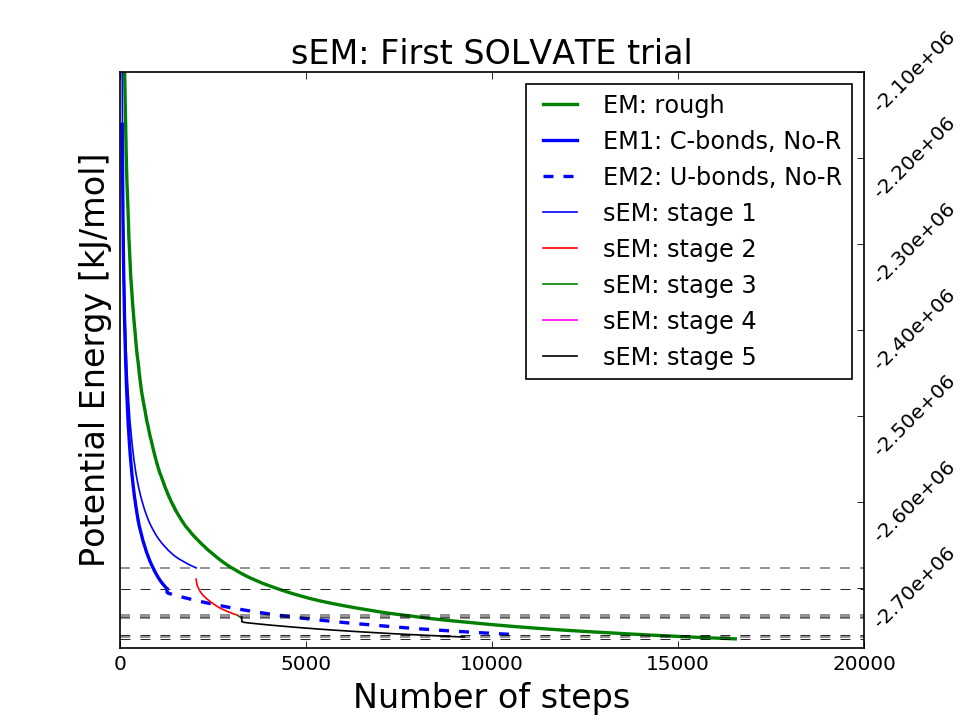

In [1033]:
fig_em, ax = plt.subplots(dpi=120)
################################# % COMPARISON % #################################
################################# % Rough EM: unconstrained bonds, unrestrained groups
f_path = path+"em/energy_em_unconstrained.xvg"
lines = filter_xvg(f_path)
stepn = [float(l) for l in lines[0]]
energy = [float(l) for l in lines[1]]

ax.plot(stepn[50:], energy[50:], color="green",linewidth=2,label="EM: rough")
ax.plot((0,20000), (energy[-1],energy[-1]), color="black", linewidth=0.5, linestyle="--" )    
################################# % EM: constrained bonds, unrestrained groups (PART 1)
f_path = path+"em/energy_em.xvg" # constrained bonds
lines = filter_xvg(f_path)
stepn = [float(l) for l in lines[0]]
energy = [float(l) for l in lines[1]]

ax.plot(stepn[50:], energy[50:], color="blue", linewidth=2, label="EM1: C-bonds, No-R")
ax.plot((0,20000), (energy[-1],energy[-1]), color="black", linewidth=0.5, linestyle="--" )

previous = stepn[-1]
################################# % EM: unconstrained bonds, unrestrained groups (PART 2)
f_path = path+"em/energy_em_unconstrained_after_em_constrained_rough.xvg" 
lines = filter_xvg(f_path)
stepn = [float(l)+previous for l in lines[0]]
energy = [float(l) for l in lines[1]]

ax.plot(stepn, energy, color="blue", linewidth=2, linestyle="--",label="EM2: U-bonds, No-R")
ax.plot((0,20000), (energy[-1],energy[-1]), color="black", linewidth=0.5, linestyle="--" )
################################# % Smooth Energy Minimization %
c_stepn = 0 # Counter 
for i in range(len(energy_files)):
    f_path = path+energy_files[i]
    lines = filter_xvg(f_path)
    # save data
    stepn = [float(l)+c_stepn for l in lines[0]] 
    energy = [float(l) for l in lines[1]]
    c_stepn = stepn[-1]
    if i == 0 :
        ax.plot(stepn[30:], energy[30:], color=colors[i], label="sEM: stage "+str(i+1))
        ax.plot((0,20000),(energy[-1],energy[-1]),linestyle="--",color="black",alpha=0.5)
    else:
        ax.plot(stepn,energy, color=colors[i], label="sEM: stage "+str(i+1))
        ax.plot((0,20000),(energy[-1],energy[-1]),linestyle="--",color="black",alpha=0.5)
################################# % Customize plot %
ax.set_title("sEM: First SOLVATE trial", fontsize=20)

ax.set_xlabel("Number of steps", fontsize=20)
ax.set_ylabel("Potential Energy [kJ/mol]", fontsize=20)
# ax.yaxis.set_label_position("right")

ax.set_xlim(0,20000)
ax.set_ylim(-2.77*1e6,-2.1*1e6)

y_labels = ax.get_yticks()
ax.set_yticklabels(['%.2e' % y for y in y_labels], rotation=45)
ax.yaxis.tick_right()
#################################
plt.legend()
plt.show()

### Second SOLVATE protocol trial,  sEM trial

In [1034]:
sem_stages = [
"PR-POPC_SC+BB_Protein_Cbonds",
"PR-SC+BB_Protein_Cbonds",
"PR-BB_Protein_Cbonds",
"No-PR_Cbonds",
"No-PR_Ubonds"
]

energy_files = ["em/energy_sem_"+name+".xvg" for name in sem_stages]

In [1035]:
path = '/projects/s21/ba13026/mytest/test3/output/complex/test_repeat/'

<IPython.core.display.Javascript object>


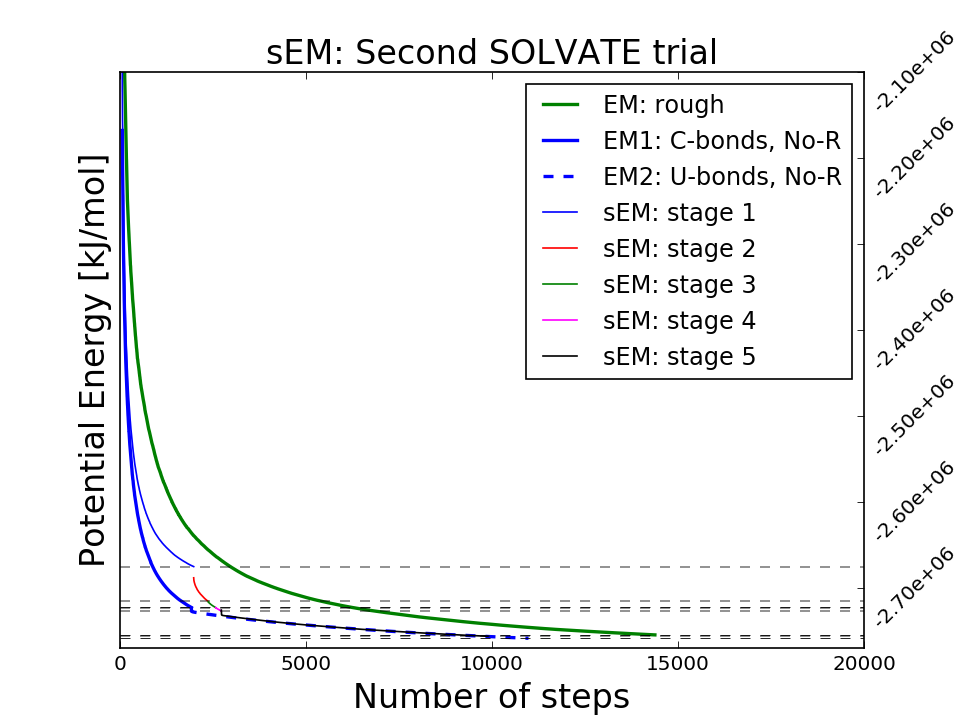

In [1036]:
fig_e2, ax2 = plt.subplots(dpi=120)
################################# % COMPARISON % #################################
################################# % Rough EM: unconstrained bonds, unrestrained groups
f_path = path+"em/energy_em_No-PR_Ubonds.xvg"
lines = filter_xvg(f_path)
stepn = [float(l) for l in lines[0]]
energy = [float(l) for l in lines[1]]

ax2.plot(stepn[50:], energy[50:], color="green",linewidth=2,label="EM: rough")
ax2.plot((0,20000), (energy[-1],energy[-1]), color="black", linewidth=0.5, linestyle="--" )    
################################# % EM: constrained bonds, unrestrained groups (PART 1)
f_path = path+"em/energy_em_No-PR_Cbonds.xvg" # constrained bonds
lines = filter_xvg(f_path)
stepn = [float(l) for l in lines[0]]
energy = [float(l) for l in lines[1]]

ax2.plot(stepn[50:], energy[50:], color="blue", linewidth=2, label="EM1: C-bonds, No-R")
ax2.plot((0,20000), (energy[-1],energy[-1]), color="black", linewidth=0.5, linestyle="--" )

previous = stepn[-1]
################################# % EM: unconstrained bonds, unrestrained groups (PART 2)
f_path = path+"em/energy_em_No-PR_Ubonds_After_Cbonds.xvg" 
lines = filter_xvg(f_path)
stepn = [float(l)+previous for l in lines[0]]
energy = [float(l) for l in lines[1]]

ax2.plot(stepn, energy, color="blue", linewidth=2, linestyle="--",label="EM2: U-bonds, No-R")
ax2.plot((0,20000), (energy[-1],energy[-1]), color="black", linewidth=0.5, linestyle="--" )
################################# % Smooth Energy Minimization %
c_stepn = 0 # Counter 
for i in range(len(energy_files)):
    f_path = path+energy_files[i]
    lines = filter_xvg(f_path)
    # save data
    stepn = [float(l)+c_stepn for l in lines[0]] 
    energy = [float(l) for l in lines[1]]
    c_stepn = stepn[-1]
    if i == 0 :
        ax2.plot(stepn[30:], energy[30:], color=colors[i], label="sEM: stage "+str(i+1))
        ax2.plot((0,20000),(energy[-1],energy[-1]),linestyle="--",color="black",alpha=0.5)
    else:
        ax2.plot(stepn,energy, color=colors[i], label="sEM: stage "+str(i+1))
        ax2.plot((0,20000),(energy[-1],energy[-1]),linestyle="--",color="black",alpha=0.5)
################################# % Customize plot % 
ax2.set_title("sEM: Second SOLVATE trial", fontsize=20)

ax2.set_xlabel("Number of steps", fontsize=20)
ax2.set_ylabel("Potential Energy [kJ/mol]", fontsize=20)
# ax.yaxis.set_label_position("right")

ax2.set_xlim(0,20000)
ax2.set_ylim(-2.77*1e6,-2.1*1e6)

y_labels = ax2.get_yticks()
ax2.set_yticklabels(['%.2e' % y for y in y_labels], rotation=45)
ax2.yaxis.tick_right()
#################################
plt.legend()
plt.show()

### sEM trial, iced-water based solvation protocol

In [1037]:
sem_stages = [
"PR-POPC_SC+BB_Protein_Cbonds",
"PR-SC+BB_Protein_Cbonds",
"PR-BB_Protein_Cbonds",
"No-PR_Cbonds",
"No-PR_Ubonds"
]

energy_files = ["em/energy_sem_"+name+".xvg" for name in sem_stages]

In [1038]:
path = '/projects/s21/ba13026\
/Wza_Modeling/L-structures/rosetta/bg_test/cwza_NoWPN\
/3-analysis/md_relax/wide/output/refined1_0001_INPUT_0007_ignorechain/complex/'

<IPython.core.display.Javascript object>


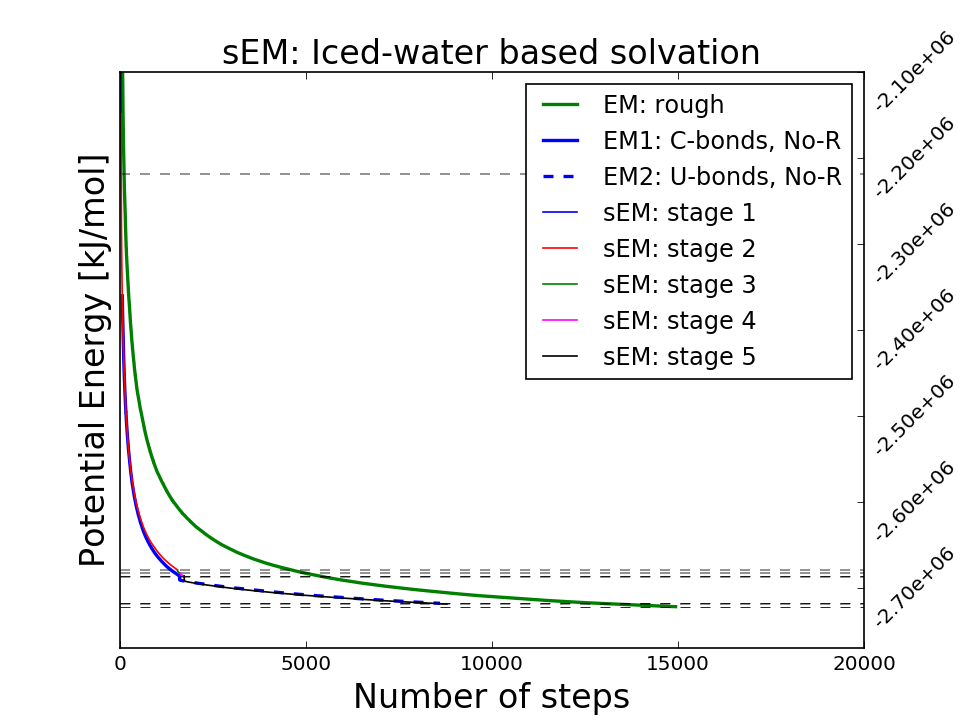

In [1039]:
fig_e3, ax3 = plt.subplots(dpi=120)
################################# % COMPARISON % #################################
################################# % Rough EM: unconstrained bonds, unrestrained groups
f_path = path+"em/energy_em_No-PR_Ubonds.xvg"
lines = filter_xvg(f_path)
stepn = [float(l) for l in lines[0]]
energy = [float(l) for l in lines[1]]

ax3.plot(stepn[50:], energy[50:], color="green",linewidth=2,label="EM: rough")
ax3.plot((0,20000), (energy[-1],energy[-1]), color="black", linewidth=0.5, linestyle="--" )    
################################# % EM: constrained bonds, unrestrained groups (PART 1)
f_path = path+"em/energy_em_No-PR_Cbonds.xvg" # constrained bonds
lines = filter_xvg(f_path)
stepn = [float(l) for l in lines[0]]
energy = [float(l) for l in lines[1]]

ax3.plot(stepn[50:], energy[50:], color="blue", linewidth=2, label="EM1: C-bonds, No-R")
ax3.plot((0,20000), (energy[-1],energy[-1]), color="black", linewidth=0.5, linestyle="--" )

previous = stepn[-1]
################################# % EM: unconstrained bonds, unrestrained groups (PART 2)
f_path = path+"em/energy_em_No-PR_Ubonds_After_Cbonds.xvg" 
lines = filter_xvg(f_path)
stepn = [float(l)+previous for l in lines[0]]
energy = [float(l) for l in lines[1]]

ax3.plot(stepn, energy, color="blue", linewidth=2, linestyle="--",label="EM2: U-bonds, No-R")
ax3.plot((0,20000), (energy[-1],energy[-1]), color="black", linewidth=0.5, linestyle="--" )
################################# % Smooth Energy Minimization %
c_stepn = 0 # Counter 
for i in range(len(energy_files)):
    f_path = path+energy_files[i]
    lines = filter_xvg(f_path)
    # save data
    stepn = [float(l)+c_stepn for l in lines[0]] 
    energy = [float(l) for l in lines[1]]
    c_stepn = stepn[-1]
    if i == 0 :
        ax3.plot(stepn[15:], energy[15:], color=colors[i], label="sEM: stage "+str(i+1))
        ax3.plot((0,20000),(energy[-1],energy[-1]),linestyle="--",color="black",alpha=0.5)
    else:
        ax3.plot(stepn, energy, color=colors[i], label="sEM: stage "+str(i+1))
        ax3.plot((0,20000),(energy[-1],energy[-1]),linestyle="--",color="black",alpha=0.5)
################################# % Customize plot % 
ax3.set_title("sEM: Iced-water based solvation", fontsize=20)

ax3.set_xlabel("Number of steps", fontsize=20)
ax3.set_ylabel("Potential Energy [kJ/mol]", fontsize=20)
# ax.yaxis.set_label_position("right")

ax3.set_xlim(0,20000)
ax3.set_ylim(-2.77*1e6,-2.1*1e6)

y_labels = ax3.get_yticks()
ax3.set_yticklabels(['%.2e' % y for y in y_labels], rotation=45)
ax3.yaxis.tick_right()
#################################
plt.legend()
plt.show()

1. Copy `posre_POPC.itp` and `topol_POPC.itp`
2. Modify line in all topology files 
3. Run *sEM extended protocol* for iced-water based solvated systems
4. Use SOLVATE based solvation protocol and run *sEM extended protocol*

Test 1:

*Working directory*

`/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwza_NoWPN/3-analysis/md_relax/`

```bash
# Specify directory
pdbname="refined1_0001_INPUT_0011_ignorechain"
path=wide/output/${pdbname}/complex

# Make essential directories
mkdir ${path}/sem
mkdir ${path}/sem/em

# Copy essential files
cp -r ~/mpmodeling/protocols/sem/mdpf ${path}/sem/
cp ~/mpmodeling/protocols/sem/topol_POPC.itp ${path}/sem/
cp ${path}/*.itp ${path}/sem/
cp ${path}/confout.gro ${path}/sem/
cp ${path}/topol.top ${path}/sem/

# Fix general topology file and generate restrain files
sed -i 's/popc_oplsaa_berger_fix.itp/topol_POPC.itp/g' ${path}/sem/topol.top
bash ~/mpmodeling/protocols/sem/gen_posres.sh ${path}/sem

# Run resolvation
bash ~/mpmodeling/protocols/resolvate_SOLVATE.sh ${path}/sem

# Run sEM
bash ~/mpmodeling/protocols/sem/sem_extended.sh ${path}/sem
```

`/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwza_NoWPN/3-analysis/md_relax/wide/output/refined1_0001_INPUT_0011_ignorechain/complex/sem`

```bash
for d in `cat pdblist_resolv-SOLVATE+sem.txt`; do bash run_resolv-SOLVATE+sem.sh $d; wait ; rm step*.pdb; rm \#*; done
```

```bash
 nohup sh -c 'for path in `cat pdblist_resolv-SOLVATE+sem.txt`; do bash ~/mpmodeling/protocols/sem/sem_extended.sh $path/complex/sem; wait; done' &
```